In [678]:
from time import sleep
import matplotlib.pyplot as plt


%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from pettingzoo.classic import connect_four_v3

import pygame

In [679]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [680]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()


#Numero de iteraciones
num_episodes = 3000


In [681]:
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.000001
TAU = 0.0005
LR = 3e-3

In [682]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

#observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84




In [683]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [684]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [685]:
class SAC:
    def __init__(self,name,lr,gamma,tau, eps_start,eps_end,eps_dec, n_observations,n_actions):

        self.name = name
        
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_observations = n_observations
        self.n_actions = n_actions

        self.policy_net = ActorNetwork(n_observations, n_actions).to(device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=LR, amsgrad=True)

        self.critic_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_1 = optim.Adam(self.critic_net_1.parameters(), lr=LR, amsgrad=True)
        self.critic_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_2 = optim.Adam(self.critic_net_2.parameters(), lr=LR, amsgrad=True)

        self.target_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_1 = optim.Adam(self.target_net_1.parameters(), lr=LR, amsgrad=True)
        self.target_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_2 = optim.Adam(self.target_net_2.parameters(), lr=LR, amsgrad=True)


        self.memory = []

        self.value_criterion = nn.MSELoss()
        self.criterion_1 = nn.MSELoss()
        self.criterion_2 = nn.MSELoss()
        self.probs = []
        self.loss = 0
        self.actor_loss = 0




    def choose_action(self, agent, state, env):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min) / (max-min)
            valid_actions = action_mask *  q_values

            print(valid_actions)
            
            # self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            #self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state, new_state, reward,done):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))

        next_action_prob = self.policy_net(state_tensor)


        next_q_target_1 = self.target_net_1(new_state_tensor)
        next_q_target_2 = self.target_net_2(new_state_tensor)

        min_next_q_target = torch.min(next_q_target_1, next_q_target_2)
        next_q = (1 * reward) + (1 - done) * self.gamma * (min_next_q_target - next_action_prob)

        Value_1 = self.critic_net_1(state_tensor)  # Doble calculo de la Q-Network
        value_2 = self.critic_net_2(state_tensor)

        loss_1 = self.criterion_1(Value_1,torch.mean(next_q))  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        loss_2 = self.criterion_2(value_2,torch.mean(next_q))  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]

        self.loss = (loss_1 + loss_2)/2

        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()

        self.loss.backward()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()




    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
        

    def save_model(self):

        # Path para guardar los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        torch.save({
                    'policy_net': self.policy_net.state_dict(),
                    'critic_net_1': self.critic_net_1.state_dict(),
                    'critic_net_2': self.critic_net_2.state_dict(),
                    'target_net_1': self.target_net_1.state_dict(),
                    'target_net_2': self.target_net_2.state_dict(),
                    }, PATH)
    
    def load_model(self):

        # Path donde se encuentran los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        checkpoint = torch.load(PATH)

        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.critic_net_1.load_state_dict(checkpoint['critic_net_1'])
        self.critic_net_2.load_state_dict(checkpoint['critic_net_2'])
        self.target_net_1.load_state_dict(checkpoint['target_net_1'])
        self.target_net_2.load_state_dict(checkpoint['target_net_2'])

        self.policy_net.eval()
        self.critic_net_1.eval()
        self.critic_net_2.eval()
        self.target_net_1.eval()
        self.target_net_2.eval()


In [686]:


sac_agent_0 = SAC(name="agent_0", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_1 = SAC(name="agent_1", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_a = SAC(name="agent_a", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)


In [687]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_0_score = []
agent_1_score = []



total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_0 = 0
last_action_player_1 = 0

previous_state = observation

for episode in range(num_episodes):
    state = env.reset()
    
    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            
            state, reward, termination, truncation, info = env.last()

            if(agent == "player_0"):
                action = sac_agent_0.choose_action(agent,state,env)
            else:
                action = sac_agent_1.choose_action(agent,state,env)
            
            env.step(action) 

            previous_state = state
            state, reward, termination, truncation, info = env.last()
            

            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)
                    
                    sac_agent_0.update(previous_state,state,env.rewards["player_0"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_1"],termination)
                    

                    break
            

        env.close()
    else:
        for agent in env.agent_iter():

            state, reward, termination, truncation, info = env.last()


            if(agent == "player_1"):
                action = sac_agent_0.choose_action(agent,state,env)
            else:
                action = sac_agent_1.choose_action(agent,state,env)

            result = env.step(action) 
            
            previous_state = state
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_1"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_0"]
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)
                    
                    sac_agent_0.update(previous_state,state,env.rewards["player_1"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_0"],termination)
                    

                    break
        env.close()

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


tensor([[0.5876, 0.4326, 0.3710, 0.2994, 1.0000, 0.3039, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5175, 0.3611, 0.8360, 0.0000, 0.1679, 1.0000, 0.5389]],
       grad_fn=<MulBackward0>)
tensor([[0.5117, 0.6757, 0.1407, 0.4156, 1.0000, 0.1209, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5654, 0.5739, 0.3149, 0.5359, 1.0000, 0.3317, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.7036, 0.0000, 0.6147, 0.3574, 0.1800, 1.0000, 0.7521]],
       grad_fn=<MulBackward0>)
tensor([[0.5870, 0.0000, 0.8125, 0.3281, 0.1204, 1.0000, 0.6021]],
       grad_fn=<MulBackward0>)
tensor([[0.5053, 0.6167, 0.3798, 0.4888, 1.0000, 0.3282, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.3483, 0.0883, 0.2420, 1.0000, 0.0545, 0.0112]],
       grad_fn=<MulBackward0>)
tensor([[0.6331, 0.0000, 0.5173, 0.4358, 0.3272, 1.0000, 0.8407]],
       grad_fn=<MulBackward0>)
tensor([[0.6995, 0.5632, 0.3495, 0.5125, 1.0000, 0.2511, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.7059, 0.4

c:\Users\koki6\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.7762, 0.0000, 0.5530, 0.4769, 0.4003, 1.0000, 0.7625]],
       grad_fn=<MulBackward0>)
tensor([[0.6179, 0.0000, 0.6312, 0.4638, 0.2591, 1.0000, 0.5761]],
       grad_fn=<MulBackward0>)
tensor([[0.4665, 0.3916, 0.0397, 0.4420, 1.0000, 0.1041, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.7552, 0.0000, 0.6591, 0.1949, 0.0838, 1.0000, 0.6556]],
       grad_fn=<MulBackward0>)
tensor([[0.4785, 0.5124, 0.5009, 0.5230, 1.0000, 0.0000, 0.2386]],
       grad_fn=<MulBackward0>)
tensor([[0.5957, 0.0000, 0.7350, 0.3363, 0.4719, 1.0000, 0.5691]],
       grad_fn=<MulBackward0>)
tensor([[0.8945, 0.0000, 0.9413, 0.4792, 0.0000, 1.0000, 0.7679]],
       grad_fn=<MulBackward0>)
tensor([[0.7861, 0.0000, 0.8733, 0.7907, 0.0000, 0.7445, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.8761, 0.0000, 0.5710, 0.4599, 0.3264, 1.0000, 0.8084]],
       grad_fn=<MulBackward0>)
tensor([[0.8117, 0.0000, 0.4924, 0.3100, 0.1950, 1.0000, 0.5928]],
       grad_fn=<MulBackward0>)
tensor([[0.7310, 0.5

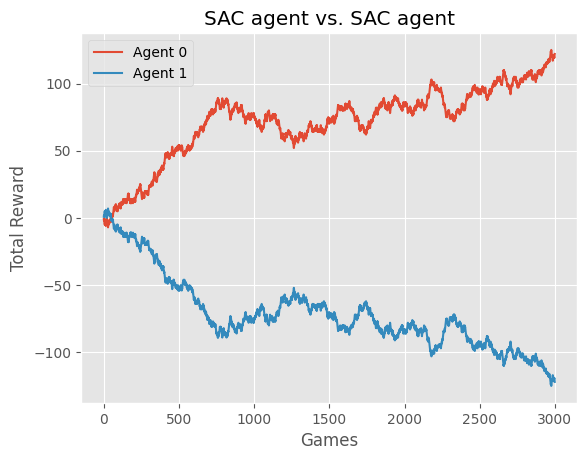

In [688]:
plt.title("SAC agent vs. SAC agent")

plt.ylabel("Total Reward")
plt.xlabel("Games")

plt.style.use("ggplot")
plt.plot(agent_0_score, label="Agent 0")
plt.plot(agent_1_score, label="Agent 1")

plt.legend()
plt.show()

In [694]:
agent_score_a = []
agent_score_r = []

# Jugadores: A (agente solitario) , R (movimientos random)

total_reward_player_a = 0
total_reward_player_r = 0
last_action_player_a = 0
last_action_player_r = 0

env.reset()
previous_state = observation

for episode in range(num_episodes):
    state = env.reset()

    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_a = total_reward_player_a + env.rewards["player_0"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_1"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_0"],termination)

                    break
            
            if(agent == "player_0"):
                action = sac_agent_a.choose_action(agent,state,env)
                env.step(action)
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
                env.step(action) 
            previous_state = state
        env.close()
    else:
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()
            
            if(agent == "player_1"):
                action= sac_agent_a.choose_action(agent,state,env)
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
            
            env.step(action) 
            previous_state = state
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    total_reward_player_a = total_reward_player_a + env.rewards["player_1"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_0"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_1"],termination)

                    break
        env.close()

print("Total score player 1: " + str(total_reward_player_a))
print("Total score player 2: " + str(total_reward_player_r))

tensor([[0.6798, 0.8185, 1.0000, 0.0000, 0.2161, 0.9515, 0.7320]],
       grad_fn=<MulBackward0>)
tensor([[0.4302, 0.9216, 0.9022, 0.1065, 0.0000, 1.0000, 0.4580]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.7418, 0.8361, 0.0000, 0.0000, 1.0000, 0.5890]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.7085, 0.0000, 0.0000, 0.0000, 0.0000, 0.5708]],
       grad_fn=<MulBackward0>)
tensor([[0.5197, 0.8996, 1.0000, 0.0000, 0.3114, 0.8039, 0.6472]],
       grad_fn=<MulBackward0>)
tensor([[0.6246, 0.9358, 1.0000, 0.0000, 0.2400, 0.9171, 0.6090]],
       grad_fn=<MulBackward0>)
tensor([[0.5626, 0.6683, 1.0000, 0.0000, 0.2106, 0.7646, 0.6885]],
       grad_fn=<MulBackward0>)
tensor([[0.2950, 1.0000, 0.9151, 0.0000, 0.1983, 0.7486, 0.8463]],
       grad_fn=<MulBackward0>)
tensor([[0.6355, 0.9726, 0.8629, 0.0000, 0.2687, 1.0000, 0.9762]],
       grad_fn=<MulBackward0>)
tensor([[0.5468, 1.0000, 0.8948, 0.0000, 0.2021, 0.9355, 0.8803]],
       grad_fn=<MulBackward0>)
tensor([[0.6368, 0.8

c:\Users\koki6\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.5682, 0.9632, 1.0000, 0.0000, 0.2259, 0.7042, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5912, 1.0000, 0.9867, 0.0000, 0.3343, 0.9230, 0.7902]],
       grad_fn=<MulBackward0>)
tensor([[0.5899, 1.0000, 0.9390, 0.0000, 0.3745, 0.9228, 0.8249]],
       grad_fn=<MulBackward0>)
tensor([[0.5036, 1.0000, 0.9392, 0.0000, 0.4922, 0.8548, 0.9219]],
       grad_fn=<MulBackward0>)
tensor([[0.5554, 0.9547, 1.0000, 0.0000, 0.5424, 0.8899, 0.9775]],
       grad_fn=<MulBackward0>)
tensor([[0.6316, 1.0000, 0.9233, 0.0000, 0.1884, 0.8967, 0.8117]],
       grad_fn=<MulBackward0>)
tensor([[0.6746, 0.8739, 1.0000, 0.0000, 0.3199, 0.7681, 0.8936]],
       grad_fn=<MulBackward0>)
tensor([[0.5989, 0.8115, 1.0000, 0.0000, 0.2897, 0.8794, 0.7833]],
       grad_fn=<MulBackward0>)
tensor([[0.4930, 0.6859, 1.0000, 0.0000, 0.1310, 0.7551, 0.5986]],
       grad_fn=<MulBackward0>)
tensor([[0.5606, 0.7659, 1.0000, 0.0000, 0.2734, 0.7999, 0.6956]],
       grad_fn=<MulBackward0>)
tensor([[0.5517, 0.8

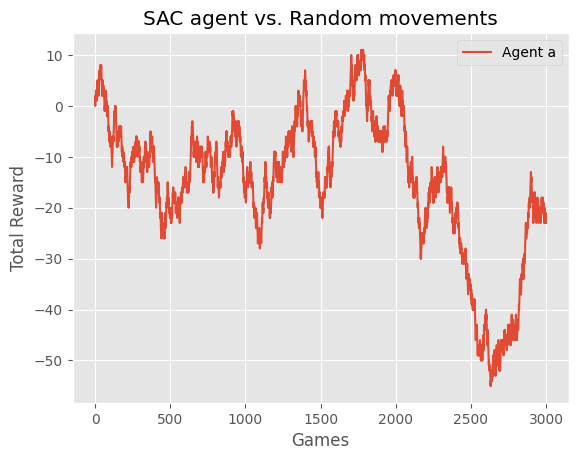

In [695]:
plt.title("SAC agent vs. Random movements")

plt.ylabel("Total Reward")
plt.xlabel("Games")

plt.style.use("ggplot")

plt.plot(agent_score_a, label="Agent a")
plt.legend()
plt.show()

In [691]:
#sac_agent_0.save_model()
#sac_agent_1.save_model()
#sac_agent_a.save_model()

In [692]:
#sac_agent_0.load_model()
#sac_agent_1.load_model()
#sac_agent_a.load_model()

In [693]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://pettingzoo.farama.org/content/basic_usage/
https://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20
https://github.com/haarnoja/sac/blob/master/sac/algos/sac.py
https://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py
https://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py
https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py
https://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb
https://gist.github.com/jskDr/9173432937ca00755be849f14672e98c
https://www.toptal.com/deep-learning/pytorch-reinforcement-learning-tutorial
https://pylessons.com/Epsilon-Greedy-DQN
https://github.com/Felhof/DiscreteSAC/blob/main/Discrete_SAC_Agent.py
https://github.com/vy007vikas/PyTorch-ActorCriticRL/blob/master/train.py
https://github.com/thomashirtz/soft-actor-critic/tree/main
https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
https://towardsdatascience.com/adapting-soft-actor-critic-for-discrete-action-spaces-a20614d4a50a


"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://pettingzoo.farama.org/content/basic_usage/\nhttps://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20\nhttps://github.com/haarnoja/sac/blob/master/sac/algos/sac.py\nhttps://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py\nhttps://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py\nhttps://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py\nhttps://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f\nhttps://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py\nhttps://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb\nhttps://gist.github.com/jskDr/9173432937ca00755be